import tensorflow as tf  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
session = tf.Session(config=config)  

In [1]:
# OpenGym CartPole-v0 with A3C on GPU
# -----------------------------------
#
# A3C implementation with GPU optimizer threads.
# 
# Made as part of blog series Let's make an A3C, available at
# https://jaromiru.com/2017/02/16/lets-make-an-a3c-theory/
#
# author: Jaromir Janisch, 2017

In [ ]:
def calc_dimensions(env):
    n_actions = env.action_space.n
    obs_shape = env.observation_space.shape
    height = obs_shape[0]//2; width = obs_shape[1]//2; n_frames = 4
    state_shape = (height, width, n_frames)
    return (state_shape, n_actions)

def start(threads):
    for thread in threads:
        thread.daemon=True
        thread.start()

def stop(threads):
    for thread in threads:
        thread.stop()
    for thread in threads:
        thread.join()

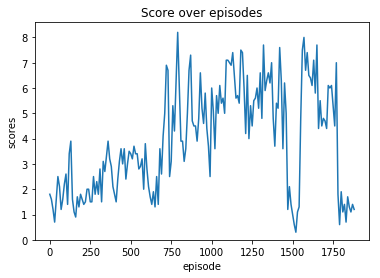

In [ ]:
import numpy as np
import gym, time, random

from ai_agent import Agent
from ai_environment import Environment
from ai_brain import Brain
from ai_optimizer import Optimizer
from util_plotter import Plotter
from util_persistence import Persister
%matplotlib inline  

ENV = 'BreakoutDeterministic-v4'
RUN_TIME = 15*60
THREADS = 8
OPTIMIZERS = 4
weights_name = "data/a3c_weights.h5"
rewards_file = 'data/rewards.csv'

#Shapes 
state_shape, actions_shape = calc_dimensions(gym.make(ENV))

# Rewards
global rewards
db = Persister(rewards_file)
rewards = db.read()

# Brain
brain = Brain(state_shape, actions_shape, model_weights=weights_name)

# Threads
envs = [Environment(gym.make(ENV), rewards, Agent(brain, actions_shape, len(rewards))) for i in range(THREADS)]
opts = [Optimizer(brain) for i in range(OPTIMIZERS)]
plotters = [Plotter(rewards)]

# Main
try:
    start(opts); start(envs); start(plotters)
    for i in range(0, RUN_TIME, 15):
        time.sleep(15)
finally:
    stop(envs); stop(opts); stop(plotters)
    brain.save_weights(weights_name)
    db.write(rewards) 
    
    print("Training finished")


In [ ]:
test_env = gym.make(ENV)
agent_test = Agent(brain, actions_shape, eps_start=0., eps_end=0.)
env_test = Environment(test_env, agent_test, render=True)
env_test.run()